In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pydot
import os
import matplotlib.pyplot as plt
import copy
import time
from collections import Counter
import scene
import AllegroWrapper
import contact
import motion_planning
import search
import visualizations
from pydrake.all import StartMeshcat
from manipulation.utils import ConfigureParser

In [2]:
meshcat = None

In [3]:
p_W_brick = [np.random.uniform(0.4, 0.75), np.random.uniform(-0.35, 0.35), 0.01]
R_W_brick = None
meshcat, station, simulator, context, p_W_brick, R_W_brick = scene.init_scenario(brick_location=p_W_brick, brick_rotation=R_W_brick, meshcat=meshcat)

allegro = AllegroWrapper.AllegroHand(station, context)
simulator.set_target_realtime_rate(1.0)
x0 = station.GetOutputPort("iiwa+allegro.state_estimated").Eval(context)
# scene.render_station_diagram(station)

def reset_arm(station, simulator, context, x0):
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, x0)
    simulator.AdvanceTo(context.get_time() + 1)

reset_arm(station, simulator, context, x0)

INFO:drake:Meshcat listening for connections at http://localhost:7003


[ 0.33820428 -0.00396487  0.72750089] [ 0.33820428 -0.00396487 -0.05      ]
Table height:  -0.0007372329446954217
[0.5289473684210526, -0.20263157894736838, -0.0007372329446954217]
[0.5289473684210526, -0.20263157894736838, -0.0007372329446954217]
[ 0.36488255 -0.00396527  0.1376619 ] [0.5289473684210526, -0.20263157894736838, -0.0007372329446954217]


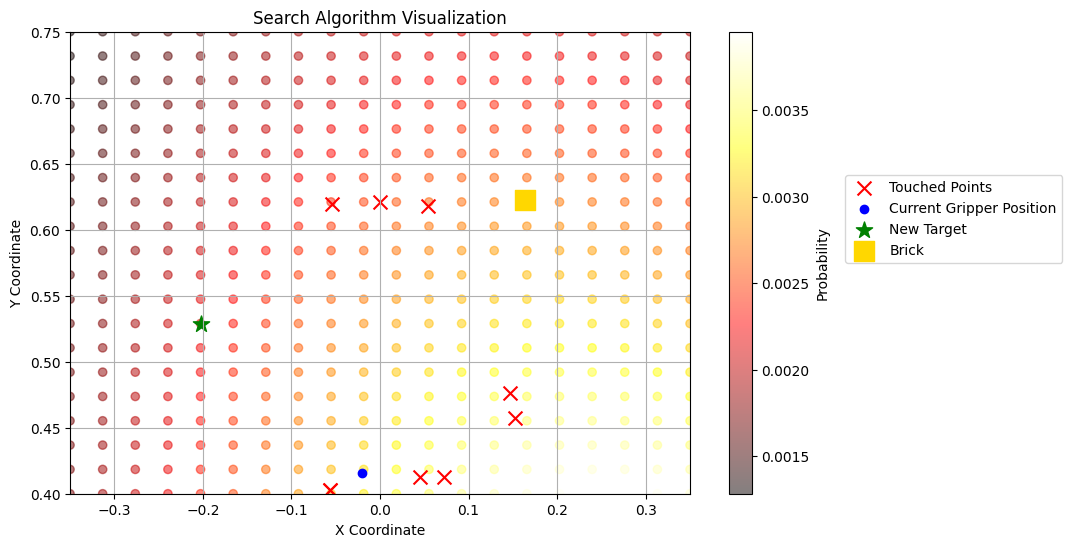

[0.5289473684210526, -0.05526315789473685, -0.0007372329446954217]
[0.5289473684210526, -0.05526315789473685, -0.0007372329446954217]
[ 0.41580406 -0.02001249  0.14640577] [0.5289473684210526, -0.05526315789473685, -0.0007372329446954217]


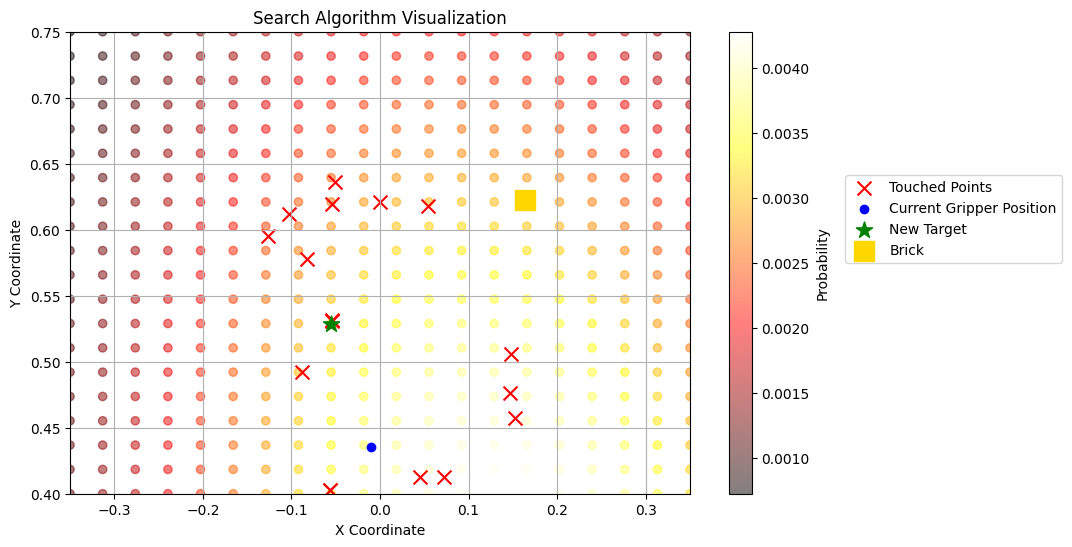

[0.5289473684210526, -0.09210526315789469, -0.0007372329446954217]
[0.5289473684210526, -0.09210526315789469, -0.0007372329446954217]
[ 0.43545528 -0.01068946  0.15084783] [0.5289473684210526, -0.09210526315789469, -0.0007372329446954217]


KeyboardInterrupt: 

In [4]:
def run_search(station, frame = "iiwa_link_6", object_bias=None):
    plant = station.GetSubsystemByName("plant")
    all_touched_points = set()

    # Get initial pose of the gripper by using default context of manip station.
    gripper = plant.GetBodyByName(frame)
    plant_context = plant.GetMyContextFromRoot(context)
    
    X_WG = plant.EvalBodyPoseInWorld(plant_context, gripper)
    table_end_effector_poses = contact.get_table_contact(X_WG)
    p_WG_post = table_end_effector_poses[-1].translation()
       
    obj_touched, new_contacts = motion_planning.move_arm(p_WG_post, simulator, station, context, time_interval=0.4, frame=frame)
    
    if obj_touched == "table":
        table_height = min(new_contacts[:, 2])
        touched_point = new_contacts[np.random.choice(np.arange(len(new_contacts)))]
        print("Table height: ", table_height)
    else:
        print("Table not found")
        # NOTE: Here we should feed coordinates into search algorithm

    for point in new_contacts:
        all_touched_points.add(tuple(point))

    i = 0
    while obj_touched == "table":
        #reset_arm(station, simulator, context, x0)
        if i > 30:
            break
        i += 1
        
        object_bias = search.update_target_bias(all_touched_points, object_bias)
        next_touch = search.sample_new_target(touched_point, all_touched_points, target_bias=object_bias)
        next_point = [next_touch[0], next_touch[1], table_height]
        print(next_point)
        #next_point = p_W_brick
        X_WG = plant.EvalBodyPoseInWorld(plant_context, gripper)

        print(next_point)
        # NOTE: This can change if there's biases in the search algorithm, based on the object's height and expected distance from the gripper
        # NOTE: We might also modify it based on some energy constraint, to minimize movement costs
        arc_height = 0.25 
        obj_touched, new_contacts = motion_planning.move_arm(next_point, simulator, station, context, time_interval=0.4, frame=frame, arc_height=0.25)
        for point in new_contacts:
            all_touched_points.add(tuple(point))


        X_WG = plant.EvalBodyPoseInWorld(plant_context, gripper)
        fig = visualizations.plot_2d_search(X_WG.translation(), all_touched_points, next_touch, object_bias, p_W_brick)
        plt.show()

    print("Object found! Location at: ", next_touch)
    print("Actual object location: ", p_W_brick)
    print("Difference: ", np.linalg.norm(np.array(next_touch) - np.array(p_W_brick[:2])))
    return all_touched_points

all_touched_points = run_search(station, object_bias = [p_W_brick[0], p_W_brick[1], 1, 1])



In [20]:
list(all_touched_points)

[(0.5007516049718239, 0.15685183070394967, -0.0025008994535185257),
 (0.6745622073496808, -0.3635824439002945, -6.508885402076517e-05),
 (0.6832596702177962, 0.051914935883076344, -0.00011355570230174236),
 (0.6913165352423796, -0.3229457804141197, -7.694215995510123e-05),
 (0.7428463577592372, -0.24147444600723666, 0.04783291974313987),
 (0.6278358084354363, -0.07445390129469373, -0.0027619341089704322),
 (0.6260979794745107, -0.07186580561721792, -0.00046458195200493706),
 (0.5026816979983562, 0.15863306920504538, -0.00016116878773642096),
 (0.5041108075804248, 0.11469206180458505, -0.00044357699368325655)]